# 1D Optimal Classifier Compared With a Simple Neural Network

This tutorial is part of the [EFI Data Analytics for Physics](https://indico.cern.ch/event/676637/) workshop. It is meant for the beginner HEP undergraduate or graduate student (or postdoc/faculty) who wants to get started  implementing a simple feed-forward Neural Network in [Python](https://docs.python.org/3/tutorial/) with [Keras](https://keras.io). A more advanced Keras tutorial on "Deep learning with images" will follow later in the afternoon. This tutorial aims to teach you key concepts and apply what you have learned in the talks and morning hands-on sessions on using Python for scientific compyting with [Jupyter](http://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html) notebooks. Basic familiarity with Python, Jupyter, and [numpy](http://www.numpy.org) is assumed. The tutorial uses [Matplotlib](https://matplotlib.org), which is the de-facto plotting utility for Python. Don't worry if you are not yet familiar with Matplotlib, we will provide what you need. Basic Keras functionality will be briefly explained as it is introduced in the exercises below. Below are some suggested excercies for you to think about and discuss with your fellow mates. However, feel free to play around and modify the notebook as you like.

This tutorial was develped by Ben Nachman (UC Berkeley) and Joakim Olsson (University of Chicago). If you are  interested in a similar tutorial using some ATLAS simualated data there is another [tutorial](https://github.com/UTA-HEP-Computing/DSatHEP-Tutorial/blob/master/IntroToDLwithKeras.ipynb) for that by by Amir Farbin at University of Texas at Arlington.

## Exercises

### 1.) Run through the notebook 
We recommend that you first run and read through the tutorial carefully one time, don't hesitate to ask us question of something is not clear :)

### 2.) Try changing things
After you have done that, it's time to start tweaking some parameters and play around with the code. Here are a few suggestions of what you can try:
#### 2a).  Try changing the number of samples (N)
What happens if you reduce the number of samples by an order of magnitude or more? If you don't see any effect, try to reduce it further. Which model does better as the number of events goes to zero? Why?
#### 2b). Vary the Network structure
What happens if you increase the number neurons in the hidden layer? What happens if you increase/decrease the number of training epochs? What happens if you vary the batch size? What happens if you change the [activation function](https://keras.io/activations/) (in particular try switching from 'sigmoind' to 'linear')?


Let's get started and import some packages that we'll need throughout the tutorial.

In [1]:
# Import the print function that is compatible with Python 3
from __future__ import print_function
# Import numpy - the fundamental package for scientific computing with Python
import numpy as np
# Import plotting Python plotting from matplotlib
import matplotlib.pyplot as plt 

## 1D Optimal Classifier

We will start by implementing the optimal (Gaussian) 1D classifier, like Ben Nachman explained in his talk 
"Introduction to pattern recognition algorithms and Machine Learning".

Numpy provides the function [numpy.random.normal](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.normal.html), which is very useful for sampling a Gaussian with a mean 'mu' and standard deviation 'sigma'. You can try out this function yourself in the cell below.

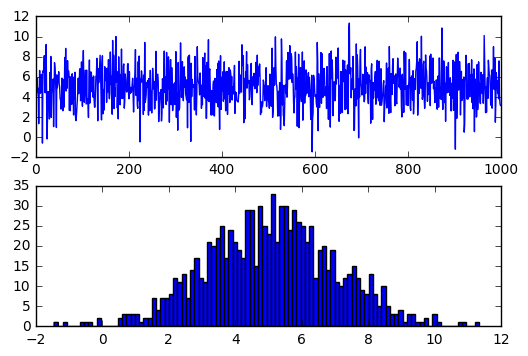

In [2]:
# Generate 1000 samples from a Gaussian pdf with mu=5 and sigma=2
mu = 5
sigma = 2
number_of_samples = 1000
test_samples = np.random.normal(mu, sigma, number_of_samples)

# Plotting with matplotlib

# First clear the figures
plt.clf()
# Segment the canvas into upper and lower subplots
plt.subplot(211)
# Plot the random numbers
plt.plot(test_samples)
plt.subplot(212)
# Histogram the numbers
plt.hist(test_samples, bins=100)
# Display the canvas
plt.show()

Let's generate some data. Below we have provided you with a function that gives you two cases:
1. ```'do_superposition = False'```: Two Gaussians, both with a standard deviation of 1, but one with mean +1 and the other with mean -1. 
2. ```'do_superposition = True'```: Signal and background are the superposition of two Gaussians whose parameters are given below. By construction, the overlap between signal and background is larger in this second case.

You are encouraged to experiment with your own function after you have run through the tutorial.

In [3]:
# Function that generates N signal and N background samples (note that 'do_simple' is true by default)
def generate_samples(N, do_superposition=False):
    
    # Case 1: Signal and background are each a single Gaussian
    if not do_superposition:
        
        # Signal Gaussian has mean 1 and standard deviation 1
        mu1, sigma1 = 1, 1
        signal = np.random.normal(mu1, sigma1, N)
        
        # Background Gaussian has mean 1 and standard deviation 1
        mu1, sigma1 = -1, 1
        background = np.random.normal(mu1, sigma1, N)
        
    # Case 2: Signal and background are superpositions of Gaussians
    else:
        
        mu1a, sigma1a = -1.1, 0.5
        x1a = np.random.normal(mu1a, sigma1a, int(0.6*N))
        mu1b, sigma1b = 1, 1
        x1b = np.random.normal(mu1b, sigma1b, int(0.4*N))
        
        mu2a, sigma2a = 2, 0.5
        x2a = np.random.normal(mu2a, sigma2a, int(0.7*N))
        mu2b, sigma2b = -1, 1
        x2b = np.random.normal(mu2b, sigma2b, int(0.3*N))

        signal = np.append(x1a,x1b)
        background = np.append(x2a,x2b)
    

    return signal, background

Now, let's actually run the function and generate some data.

In [4]:
# If 'do_superposition = True' we get multiple Gaussians
do_superposition = True
# Number of samples
N = 10000000
# Number of bins in the histograms
nbins = 500

# Generate signal and background
signal, background = generate_samples(N, do_superposition)

Often when dealing with data you may want to either save something you generated or load data you got from somebody else. One of the most common formats is HDF5, a "data model, library, and file format for storing and managing data." It is also the most common storage format in data science. h5py provides a python API for HDF5. In most cases, you do not need to know very much about HDF5 or h5py, just how to read/write tensors into/from files, which you can easily pick up from the h5py (Quick Start)[http://docs.h5py.org/en/latest/quick.html]. 

Even though this tutorial could be completed without storing and retreiving the data, it may be useful to go through that exercise. 

Let's start by save the data you generated to HDF5. 

In [5]:
import h5py
# create a new file
h5_file = h5py.File("data1.h5", "w")
h5_file.create_dataset('signal', data=signal)
h5_file.create_dataset('background', data=background)
h5_file.close()

Here's how we can retreive the data back.

In [6]:
h5_file_readonly = h5py.File('data1.h5','r')
signal = h5_file_readonly['signal'][:]
background = h5_file_readonly['background'][:]
h5_file_readonly.close()

Create histograms and plot the data.

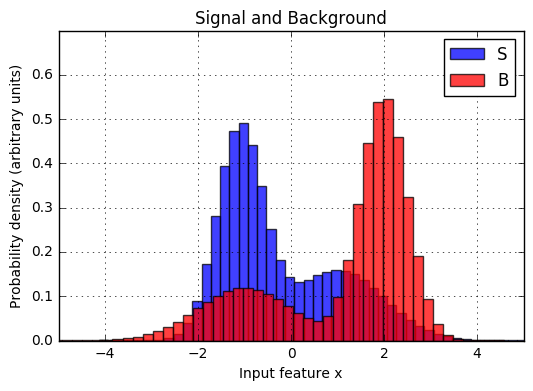

In [7]:
# Plot the histograms
plt.clf()
plt.hist(signal, 50, density=True, facecolor='blue', alpha=0.75, label='S')
plt.hist(background, 50, density=True, facecolor='red', alpha=0.75, label='B')
plt.xlabel('Input feature x')
plt.ylabel('Probability density (arbitrary units)')
plt.title(r'Signal and Background')
plt.legend(loc='upper right')
plt.axis([-5, 5, 0, 0.7])
plt.grid(True)
plt.show()

Next, let's compute the log-likelihood ratio (LLR).

In [8]:
# Create the histograms, which we will use for calculating the log-likelihood ratio (LLR) below
h_signal = np.histogram(signal, bins=500, range=(-5,5))
h_background = np.histogram(background, bins=500, range=(-5,5))

LL_dict = {} # used only for plotting
LL_dict_bybin = {} # used for computing

for i in range(len(h_signal[0])):
    
    # the if statements are there to account for "binning effects"
    if (h_background[0][i] > 0 and h_signal[0][i] > 0):
        LL_dict[h_background[1][i]] = np.log(1.*h_signal[0][i]/h_background[0][i])
    elif (h_signal[0][i] > 0): # in case background bin = 0
        LL_dict[h_background[1][i]] = np.log(100000.) #huge number
    elif (h_background[0][i] > 0): # in case signal bin = 0
        LL_dict[h_background[1][i]] = np.log(1./100000.) #very small number
    else: 
        LL_dict[h_background[1][i]] = np.log(1.)
    
    LL_dict_bybin[i] = LL_dict[h_background[1][i]]

We can also plot the mapping between the input feature vector and the LLR.

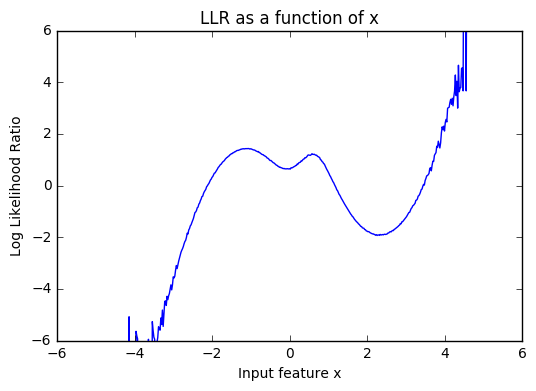

In [9]:
# array of 'x' values
xvals = [d for d in LL_dict]
# array of 'y' values
yvals = [LL_dict[d] for d in LL_dict]

xvals = np.array(xvals)
yvals = np.array(yvals)

# Return the indices that result from sorting the array (but do not modify the array itself)
index_sorted = xvals.argsort()
# Sort the arrays 
xvals = xvals[index_sorted[::-1]]
yvals = yvals[index_sorted[::-1]]

# Plot the LLR as a function of input feature x
plt.clf()
plt.plot(xvals,yvals)
plt.xlabel('Input feature x')
plt.ylabel('Log Likelihood Ratio')
plt.title(r'LLR as a function of x')
plt.axis([-6,6,-6,6])
plt.show()

Don't worry about the 'bumps' towards the edges of the plot, that's just due to low statistics.

The next step is to compute and plot the PDF of the LLR. 

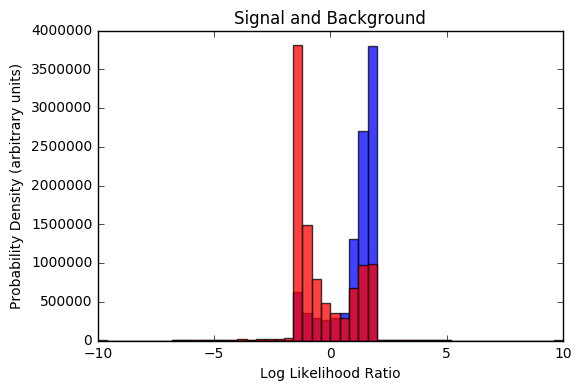

In [10]:
# Number of bins in the histgrams
nbins = 50

# Create histograms
h_signal_yvals = np.histogram([], bins=nbins, range=(-10,10))
h_background_yvals = np.histogram([], bins=nbins, range=(-10,10))

# Fill histograms
for i in range(len(h_signal[0])):
    whichbin = np.digitize(LL_dict[h_signal[1][i]], h_signal_yvals[1])
    if (whichbin > 49):
        whichbin = 49
    h_signal_yvals[0][whichbin]+=h_signal[0][i]
    h_background_yvals[0][whichbin]+=h_background[0][i]

# Plot the PDF of the LLR
plt.clf()
plt.xlabel('Log Likelihood Ratio')
plt.ylabel('Probability Density (arbitrary units)')
plt.title(r'Signal and Background')
plt.bar(h_signal_yvals[1][:-1],h_signal_yvals[0], width=h_signal_yvals[1][1]-h_signal_yvals[1][0],facecolor='blue', alpha=0.75, label='S')
plt.bar(h_background_yvals[1][:-1],h_background_yvals[0], width=h_background_yvals[1][1]-h_background_yvals[1][0],facecolor='red', alpha=0.75, label='B')
plt.show()

Finally, we can scan a threshold cut on the LLR and make the ROC curve.

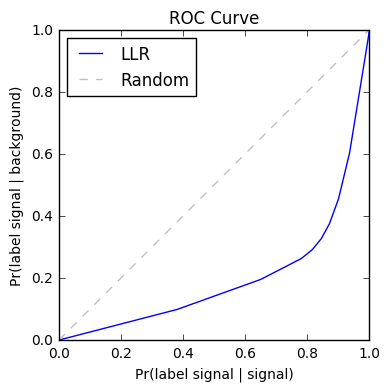

In [11]:
# Make the ROC curve
ROCx = np.zeros(nbins)
ROCy = np.zeros(nbins)
intx = 0.
inty = 0.

for i in range(nbins):
    intx+=h_signal_yvals[0][i]
    inty+=h_background_yvals[0][i]

for i in range(nbins):
    sum_signal = 0.
    sum_background = 0.
    for j in range(i,len(h_signal_yvals[1])-1):
        sum_signal+=h_signal_yvals[0][j]
        sum_background+=h_background_yvals[0][j]

    ROCx[i] = sum_signal/intx
    ROCy[i] = sum_background/inty
    
# Plot the ROC curve
plt.clf()
plt.axes().set_aspect('equal')
plt.plot(ROCx,ROCy,label="LLR")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.title(r'ROC Curve')
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left')
plt.show()

That's it for the first part of this tutorial. Now let's do some Machine Learning!

## Implement and train a simple Neural Network in Keras

Before one gets to the actual training, it's often necessary to transform the data into numpy array of the correct shape. To better understand what's going on below, let's do a quick example.

In [12]:
# Say we have two 1x3 arrays (e.g. A=signal, B=background)
A = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=np.float32)
B = np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype=np.float32)

# We want to have labels '1' associated with the signal (A) and labels '0' associated with the background (B)
A_labels = np.ones(10)
B_labels = np.zeros(10)

print('\nA: {}'.format(A))
print('B: {}'.format(B))
print('\nA_labels: {}'.format(A_labels))
print('B_labels: {}\n'.format(B_labels))

# We can concatenate the A and B arrays, and the A_labels and B_labels array like this
C = np.concatenate((A,B))
C_labels = np.concatenate((A_labels,B_labels))

print('\nC: {}'.format(C))
print('C_labels: {}'.format(C_labels))

# Before training on the a dataset one often want to split it up into a 'training set' and a 'test set'
# There is a useful function in scikit-learn that does this for you
# This function also scrambles the examples 
from sklearn.model_selection import train_test_split
C_train, C_test, C_labels_train, C_labels_test, = train_test_split(C, C_labels, test_size=3, random_state=1)

# If this seems confusing, taking a look at the print output below should hopefully make things clear
print('\nC_train: {}'.format(C_train))
print('C_labels_train: {}'.format(C_labels_train))

print('\nC_test: {}'.format(C_test))
print('\nC_labels_test: {}'.format(C_labels_test))


A: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
B: [ 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]

A_labels: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
B_labels: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


C: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.]
C_labels: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]

C_train: [ 11.   3.  15.   5.  18.   8.   2.  14.   1.  20.  19.  10.  16.   9.  13.
  12.   6.]
C_labels_train: [ 0.  1.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.]

C_test: [  4.  17.   7.]

C_labels_test: [ 1.  0.  1.]


Another things is that Keras require the 'X' inputs to be formatted in a certain way. Here's a simple example of that.

In [13]:
A = np.array([1, 2, 3, 4], dtype=np.float32)
print(A)
AT = np.array(A)[np.newaxis].T
print(AT)

[ 1.  2.  3.  4.]
[[ 1.]
 [ 2.]
 [ 3.]
 [ 4.]]


Now when we hopefully understand a little more about how to manipulate numpy arrays, let's prepare our actual data for training a Neural Network in Keras.

If you already executed the cells for generating (or loading) data in the first part of the tutorial, you should be good to go, otherwise please scroll up and execute the cell that calls:

```signal, background = generate_samples(N)```

In [14]:
# total number of signal + background events
n_signal = len(signal)
n_background = len(background)
n_total = len(signal) + len(background)

# use 90% of the total number of events for training the network
n_train = int(0.9*n_total)
# use the remaning 10% for testing
n_test = n_total-n_train

# generate an array of ones as signal labels
sig_labels = np.ones(n_signal)

# generate an array of zeros as background labels
bkg_labels = np.zeros(n_background)

# concatenate the signal and background samples
X = np.concatenate((signal,background))
y = np.concatenate((sig_labels,bkg_labels))

# Format the inputs for Keras
X = np.array(X)[np.newaxis].T

# split the dataset into a training and a validation set and scamble the inputs (as illustrated above)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=n_test, random_state=1)

Finally we get to the fun stuff, let's implement our first Neural Network in Keras. To learn more what all this does, you are strongly encouraged to go and read the [Keras documentation](https://keras.io).

The core data structure of Keras is a model, a way to organize layers. The simplest type of model is the Sequential model, a linear stack of layers. For more complex architectures, you should use the Keras functional API, which allows to build arbitrary graphs of layers.

In [15]:
from keras.models import Sequential

model = Sequential()

Using TensorFlow backend.


Now let's add some layers to our model with "Dense". Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

In other words, Dense is just your the regular densely-connected NN layer.

In [16]:
from keras.layers import Dense

# Since our samples are only the X values (of either signal or background), the first layer just has one input dimension
model.add(Dense(1, input_dim=1, kernel_initializer='normal', activation='relu'))

# We then implement only one hidden layer with 8 neurons (you can experiment with changing this number)
n_neurons_hidden = 8
model.add(Dense(n_neurons_hidden, kernel_initializer='normal', activation='relu'))

# Finally we add one output layer
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

Next, we compile our model and choose ['binary_crossentropy']('https://keras.io/losses/') as our loss function and ['ADAM' (adaptive moment estimation)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) as the optimizer (an extension of stochastic gradient descent).

In [17]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model structure
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


We then train our model in the training data. Keras automatically runs validation on the test data. 

You can experiment with the number of 'epochs' the 'batch size': 
- one epoch = One forward pass and one backward pass of all the training examples.
- batch size = The number of training examples in one forward/backward pass. Tthe higher the batch size, the more memory space you'll need.

In [18]:
history=model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=3, batch_size=2048)

Train on 18000000 samples, validate on 2000000 samples
Epoch 1/2
18000000/18000000 [==============================] - 25s - loss: 0.5436 - acc: 0.7548 - val_loss: 0.5309 - val_acc: 0.7623

This very simple model should converge very quickly (even after 1-3 epochs). Training more complicated networks can take a very long time (days, weeks, or even months). 

The model history keeps track of the loss and accuracy for each epoch. Note that the training above was setup to run on the validation sample at the end of each epoch:

In [19]:
print(history.history)

{'acc': [0.75481572222222226, 0.76180472222222217], 'loss': [0.54359853877682152, 0.53145019209882949], 'val_acc': [0.76233250001144404, 0.76217399999237057], 'val_loss': [0.53085836367034911, 0.5310138884048462]}


You can plot the loss versus epoch.

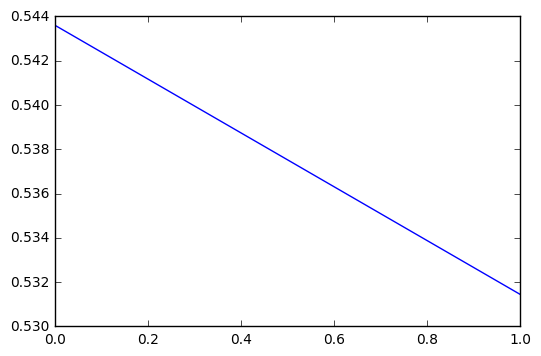

In [20]:
loss_history=history.history["loss"]
plt.plot(range(len(loss_history)),loss_history)
plt.show()

Finally, let's plot the ROC curve and compare it to the result we got form the 1D optimal classifier above.

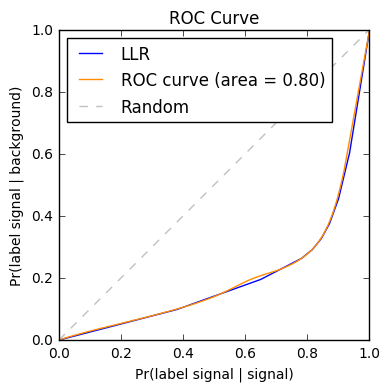

In [21]:
# Here we make use of a function in scikit-learn to calculate the ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
                        
roc_auc = auc(fpr, tpr)

# Plot the ROC curve from the NN and overlay the ROC curve from the 1D classifier
plt.clf()
plt.axes().set_aspect('equal')
plt.plot(ROCx,ROCy,label="LLR")
plt.plot(tpr,fpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.title(r'ROC Curve')
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left')
plt.show()

If you have done everything correctly, you should find that the ROC curves should overlap nicely.

Congratulations, you are now done with this tutorial. Head over to [keras.io](http://keras.io) and find some fun tutorials!